In [126]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.beh_functions import *
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session, plot_foraging_session_nwb
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import plot_lick_analysis, cal_metrics, plot_met, load_data
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
from matplotlib.gridspec import GridSpec
import json
from scipy import stats
%matplotlib inline

In [109]:
session = 'behavior_751004_2024-12-19_11-50-37'
session_dir = session_dirs(session)

In [110]:
start = 270
end = 1000
session_tbl = get_session_tbl(session)
session_tbl = session_tbl.iloc[start:end].copy().reset_index(drop=True)

In [111]:
choices = np.zeros(session_tbl.shape[0], dtype=int)
rewards = np.zeros(session_tbl.shape[0], dtype=int)
for i, row in session_tbl.iterrows():
    if row['animal_response'] == 0:
        choices[i] = -1
    elif row['animal_response'] == 1:
        choices[i] = 1
    if row['rewarded_historyL'] == 1:
        rewards[i] = -1
    elif row['rewarded_historyR'] == 1:
        rewards[i] = 1

In [112]:
# compute running ave of rewards and finish rate
window_size = 5
def running_average(arr, window_size):
    running_ave = np.convolve(arr, np.ones(window_size) / window_size, mode='valid')
    # set the original array to NaN for the first (window_size - 1) elements
    result = np.full(arr.shape, np.nan)
    result[window_size-1:] = running_ave
    return result
rewards_ave = running_average(np.abs(rewards), window_size)
response_ave = running_average(np.abs(choices), window_size)

In [118]:
session_tbl['reward_probabilityL'].values

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [124]:
block_changes_L = np.where(session_tbl['reward_probabilityL'].values[:-1] != session_tbl['reward_probabilityL'].values[1:])[0] + 1
block_changes_R = np.where(session_tbl['reward_probabilityR'].values[:-1] != session_tbl['reward_probabilityR'].values[1:])[0] + 1
block_changes = np.unique(np.concatenate((block_changes_L, block_changes_R)))
block_changes = np.sort(block_changes)
block_changes = np.concatenate((
    [0],
    block_changes,
    [len(session_tbl)]
))

In [135]:
block_probs_L = [stats.mode(session_tbl['reward_probabilityL'].values[block_changes[i]:(block_changes[i+1]-1)])[0] for i in range(len(block_changes)-1)]
block_probs_R = [stats.mode(session_tbl['reward_probabilityR'].values[block_changes[i]:(block_changes[i+1]-1)])[0] for i in range(len(block_changes)-1)]
block_centers = block_changes[:-1] + np.diff(block_changes) // 2

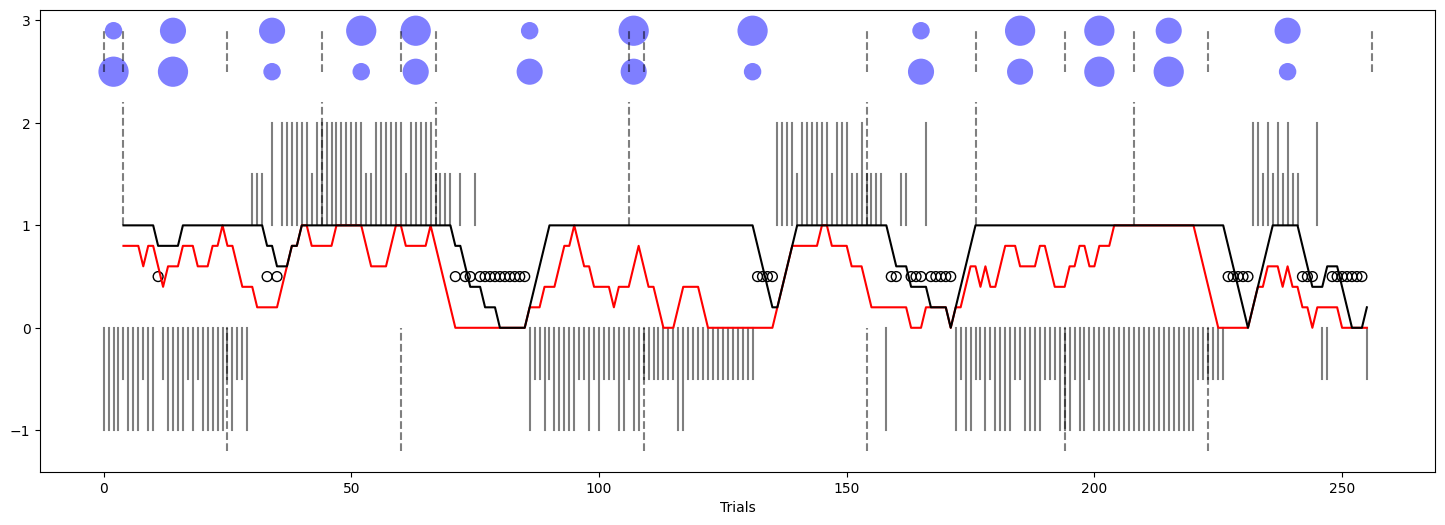

In [151]:
fig = plt.figure(figsize=(18, 6))
plt.plot(np.stack([range(len(session_tbl)), range(len(session_tbl))], axis = 1).T, np.stack([choices>0, 0.5*(choices+rewards)+(choices>0)], axis = 1).T, c='k', label='Choices', alpha=0.5)
# plt.plot(np.stack([np.where(choices==0)[0], np.where(choices==0)[0]], axis = 1).T, np.stack([np.full(np.sum(choices==0), -1), np.full(np.sum(choices==0), 1)], axis = 1).T, c='r', label='Rewards', alpha=0.5)
plt.scatter(np.where(choices==0)[0], np.full(np.sum(choices==0), 0.5), c='none', label='miss', edgecolors='k', s = 50, marker='o')
plt.plot(range(len(session_tbl)), rewards_ave, c='red', label='Running Average Rewards')
plt.plot(range(len(session_tbl)), response_ave, c='k', label='Running Average Hit')
plt.plot(np.stack([block_changes_L, block_changes_L], axis=1).T, np.stack([np.full(len(block_changes_L), -1.2), np.full(len(block_changes_L), 0)], axis=1).T, c='k', label='Block Changes L', alpha=0.5, linestyle='--')
plt.plot(np.stack([block_changes_R, block_changes_R], axis=1).T, np.stack([np.full(len(block_changes_R), 1), np.full(len(block_changes_R), 2.2)], axis=1).T, c='k', label='Block Changes R', alpha=0.5, linestyle='--')
plt.xlabel('Trials')


# scatter plot for Right reward size
plt.scatter(block_centers, np.full(len(block_centers), 2.9), c='b', label='Right Reward Probability', s=np.sqrt(np.array(block_probs_R))*500, alpha=0.5, edgecolors='none')
plt.scatter(block_centers, np.full(len(block_centers), 2.5), c='b', label='Left Reward Probability', s=np.sqrt(np.array(block_probs_L))*500, alpha=0.5, edgecolors='none')
plt.plot(np.stack([block_changes, block_changes], axis=1).T, np.stack([np.full(len(block_changes), 2.5), np.full(len(block_changes), 2.9)], axis=1).T, c='k', label='Block Changes', alpha=0.5, linestyle='--')
# scatter plot for Left reward pre_chunk_size_second
plt.savefig(os.path.join(session_dir['beh_fig_dir'], 'hit_response.pdf'))
